In [ ]:
import numpy as np
import tensorflow as tf
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import copy
import keras.backend as K
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import random
seed = 42
np.random.seed = seed

In [ ]:
import os
# import data from my google drive  
# os.listdir('/content/drive/MyDrive/')

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

path = "/content/drive/MyDrive/ECSE_458_hong/UltrasoundImages/"

Mounted at /content/drive/


In [ ]:
# load the images and masks
train_images = []
train_masks = []

load_images = glob(path + 'images/*.png')

file_names = []

for f in load_images:
    fn = os.path.basename(f)
    file_names.append(fn)
    train_images.append(Image.open(path + '/images/' + fn))
    m = np.array(Image.open(path + '/masks/' + fn))
    m[m != 204] = 0
    m[m > 200] = 255
    train_masks.append(m)

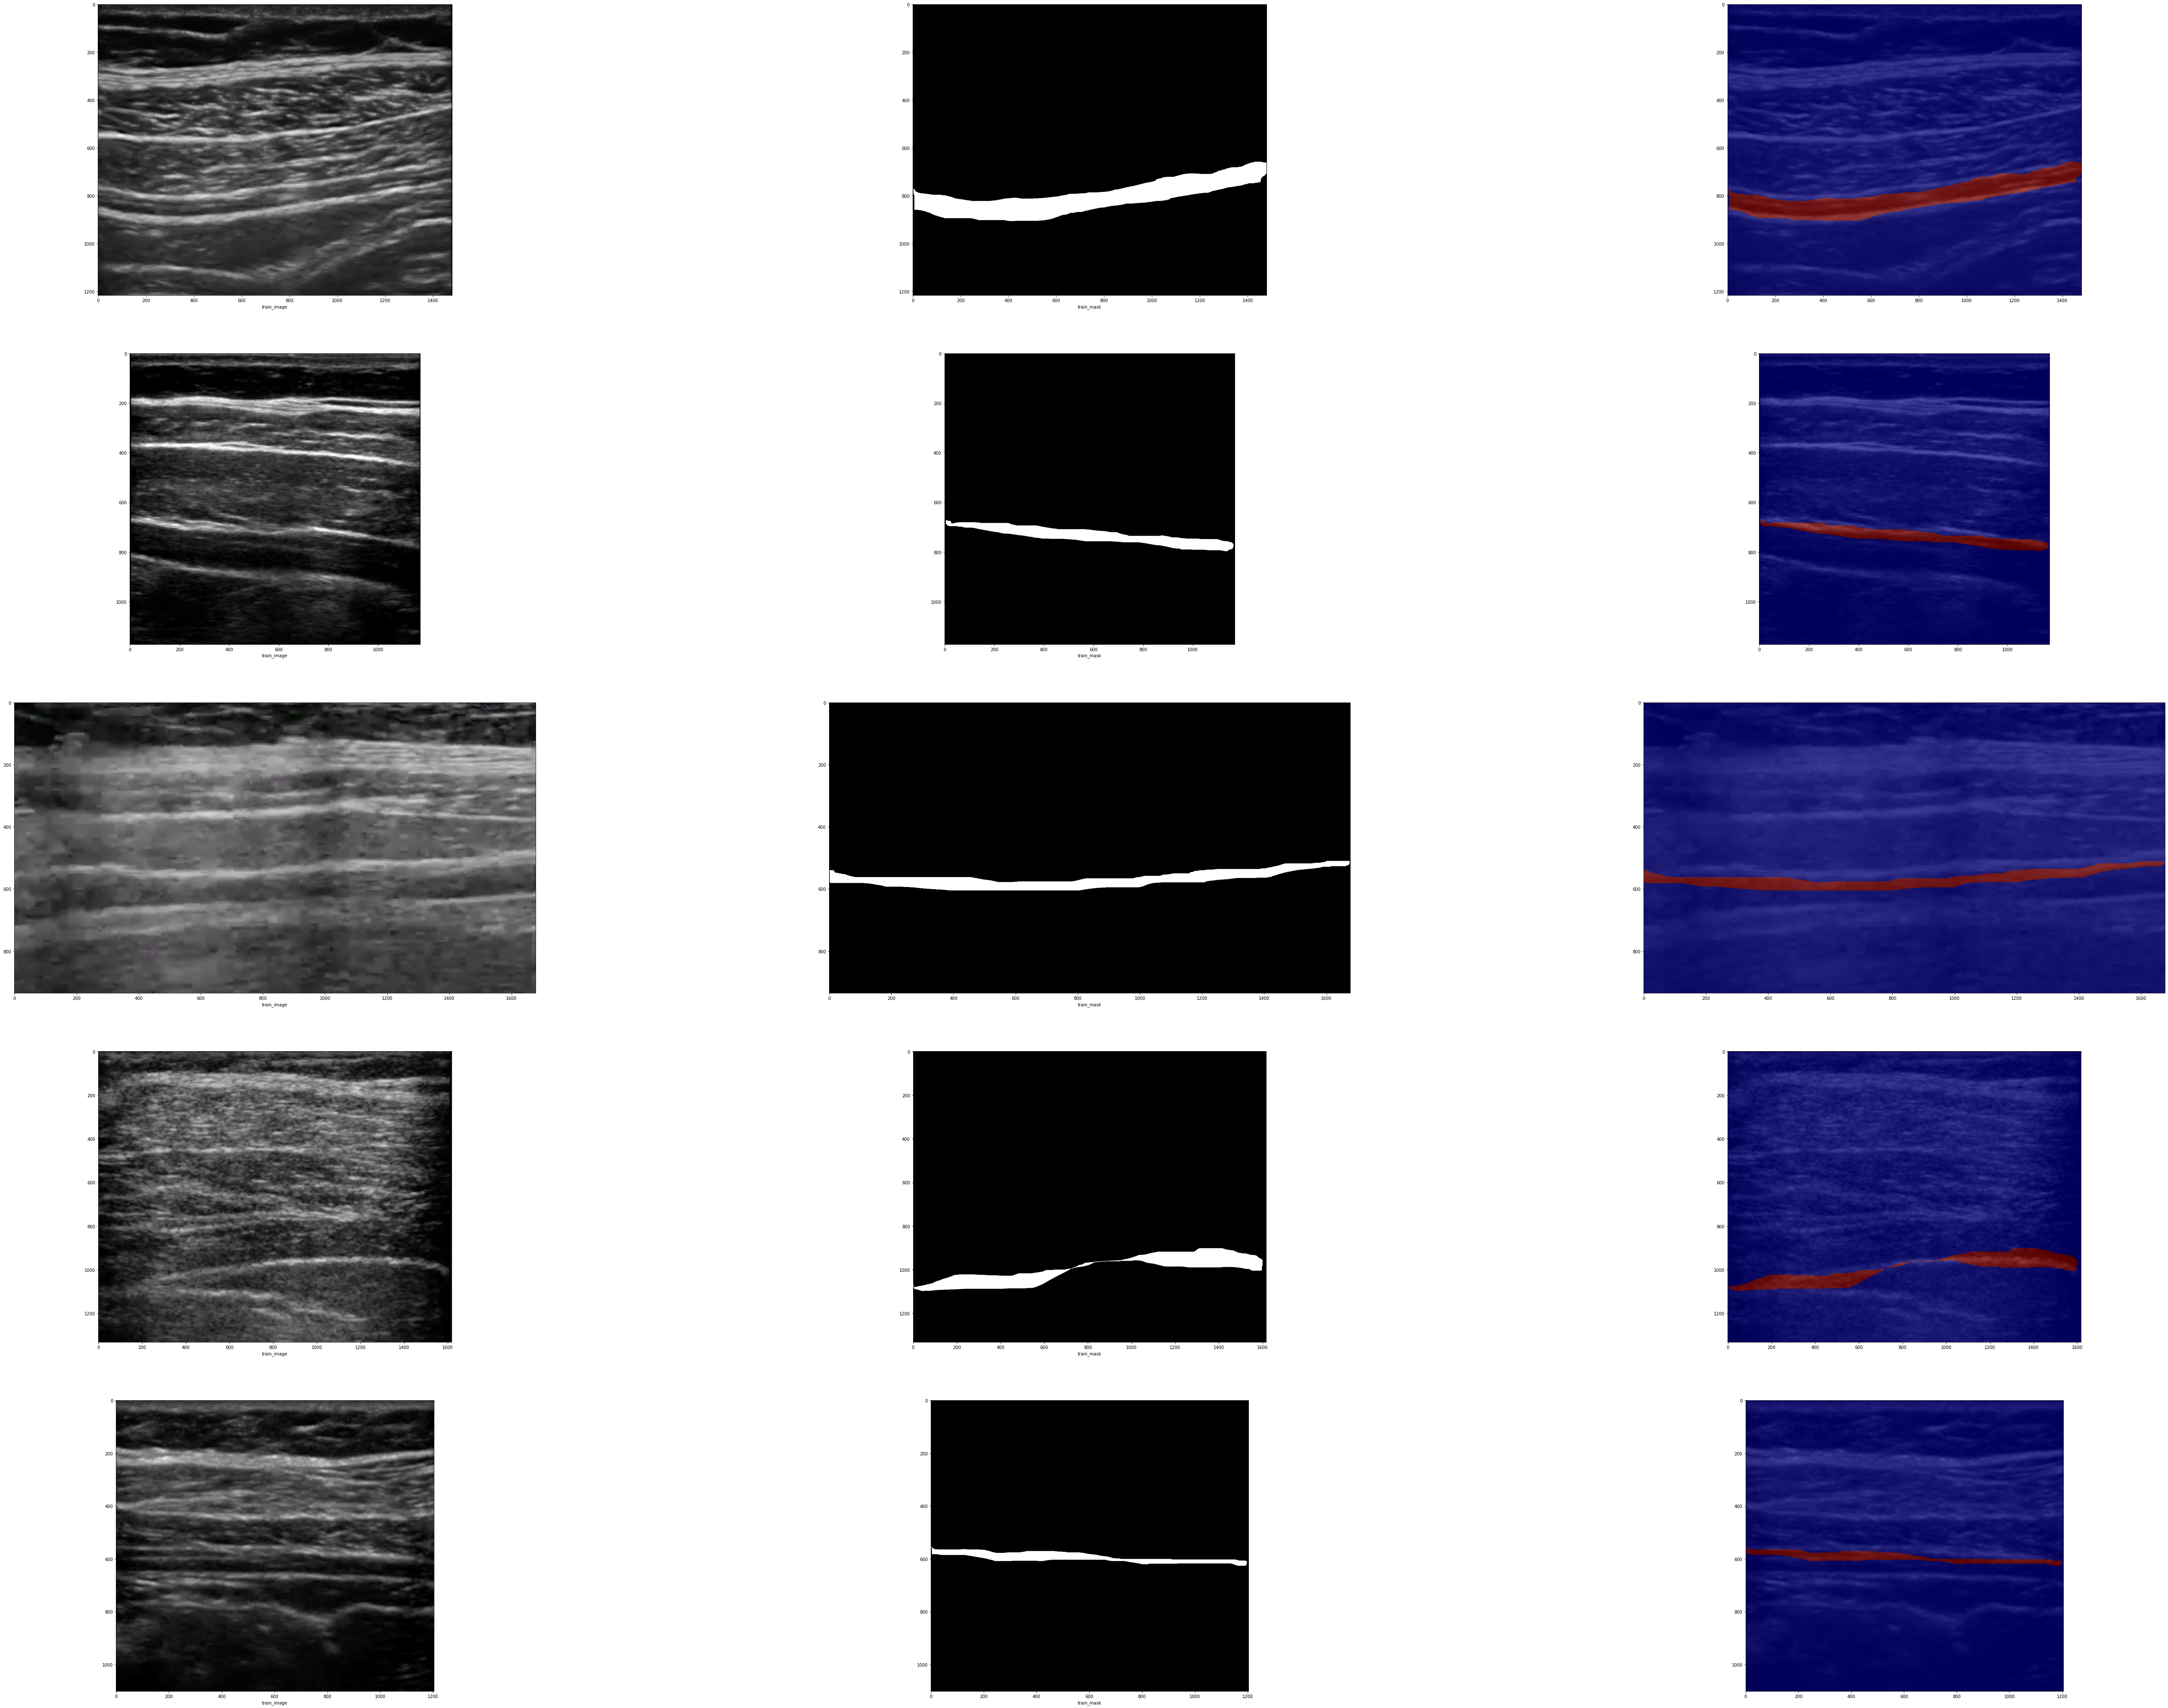

In [ ]:
# Display the first 5 images and their masks of the corresponding subjects.

mask_05 = copy.deepcopy(train_masks[:5])

fig, ax = plt.subplots(5,3,figsize = (96,72))

for i in range (0,5):
  ax[i][0].imshow(train_images[i], cmap = 'gray')
  ax[i][1].imshow(mask_05[i], cmap = 'gray')
  ax[i][2].imshow(train_images[i], cmap = 'gray', interpolation = 'none')
  ax[i][2].imshow(mask_05[i], cmap = 'jet', interpolation = 'none', alpha = 0.7)

  ax[i][0].set(xlabel="train_image")
  ax[i][1].set(xlabel="train_mask")
  
plt.show()


In [ ]:
# resizing the images
# train images
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

In [ ]:
# resizing images (X_train)
X_train = np.zeros((len(file_names), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(file_names), total=len(file_names)):

  img = imread(path + '/images/' + id_)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img

100%|██████████| 554/554 [03:19<00:00,  2.78it/s]


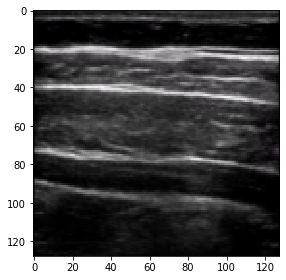

In [ ]:
imshow(X_train[1])
plt.show()

In [ ]:
# resizing masks (Y_train)
Y_train_threshed = np.zeros((len(file_names), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

mask_threshed = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
for n, id_ in tqdm(enumerate(file_names), total=len(file_names)):

  mask_ = train_masks[n]
  mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
  #mask = np.maximum(mask, mask_)

  Y_train_threshed[n] = mask_

100%|██████████| 554/554 [00:58<00:00,  9.55it/s]


100%|██████████| 554/554 [00:00<00:00, 38973.59it/s]


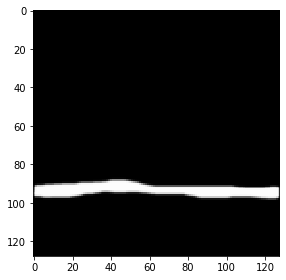

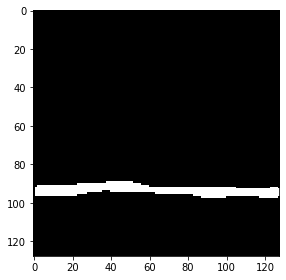

In [ ]:
Y_train = np.zeros((len(file_names), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id_ in tqdm(enumerate(file_names), total=len(file_names)):

  mask_ = Y_train_threshed[n]
  mask = mask_ >= 200
  Y_train[n] = mask

imshow(np.squeeze(Y_train_threshed[40]))
plt.show()

imshow(np.squeeze(Y_train[40]))
plt.show()

In [ ]:
# resizing test images
test_ids = file_names[:100]
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

  test = imread(path + '/images/' + id_)[:,:,:IMG_CHANNELS]
  test = resize(test, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = test

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


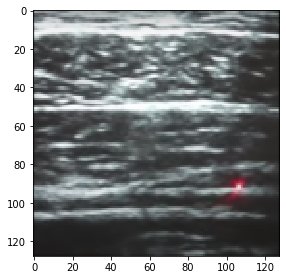

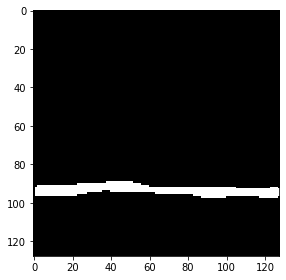

In [ ]:
imshow(np.squeeze(X_train[40]))
plt.show()

imshow(np.squeeze(Y_train[40]))
plt.show()

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def IoU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return intersection/union

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    #s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef])
    
    model.summary()
    
    return model

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=15, callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 10s 87ms/step - loss: 0.2103 - accuracy: 0.9694 - dice_coef: 0.0513 - val_loss: 0.1165 - val_accuracy: 0.9692 - val_dice_coef: 0.1492
Epoch 2/15
63/63 [==============================] - 4s 67ms/step - loss: 0.0693 - accuracy: 0.9704 - dice_coef: 0.3087 - val_loss: 0.0678 - val_accuracy: 0.9726 - val_dice_coef: 0.3403
Epoch 3/15
63/63 [==============================] - 4s 66ms/step - loss: 0.0542 - accuracy: 0.9763 - dice_coef: 0.4317 - val_loss: 0.0532 - val_accuracy: 0.9808 - val_dice_coef: 0.4744
Epoch 4/15
63/63 [==============================] - 4s 67ms/step - loss: 0.0478 - accuracy: 0.9806 - dice_coef: 0.5349 - val_loss: 0.0534 - val_accuracy: 0.9814 - val_dice_coef: 0.4777
Epoch 5/15
63/63 [==============================] - 4s 67ms/step - loss: 0.0454 - accuracy: 0.9814 - dice_coef: 0.5493 - val_loss: 0.0413 - val_accuracy: 0.9826 - val_dice_coef: 0.5771
Epoch 6/15
63/63 [==============================] - 4s 68ms/step - loss: 0

In [ ]:
!nvidia-smi
print(tf.__version__)

Sun Nov 21 00:45:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0   102W / 149W |   1316MiB / 11441MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

4/4 [==============================] - 1s 175ms/step


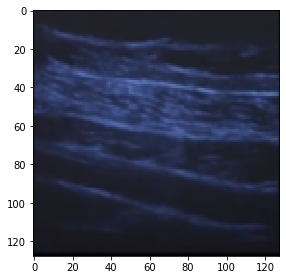

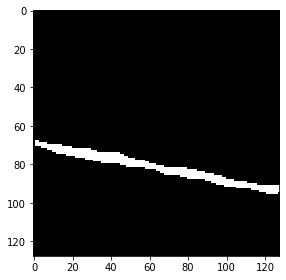

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


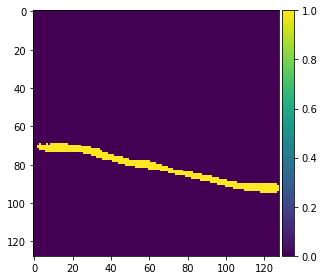

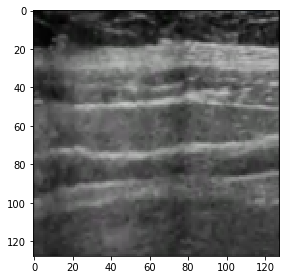

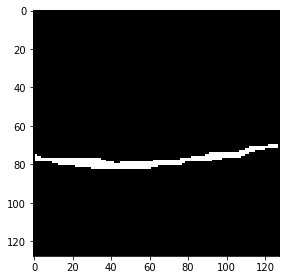

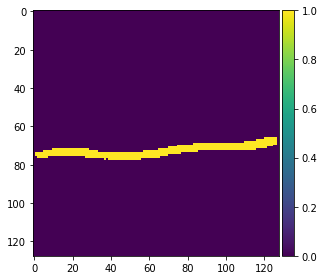

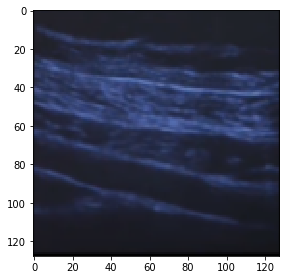

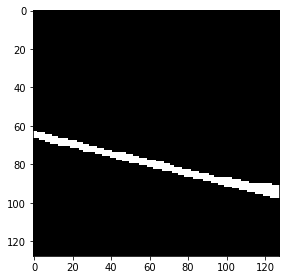

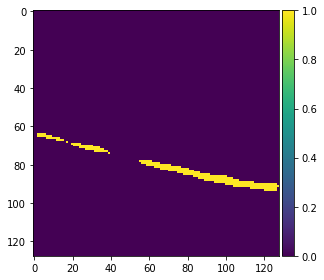

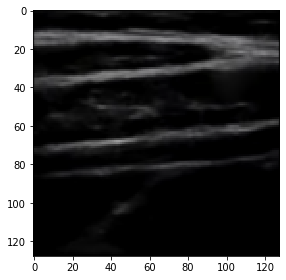

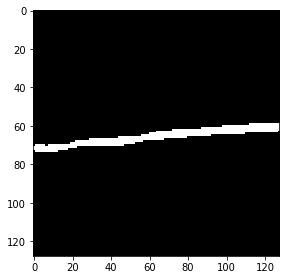

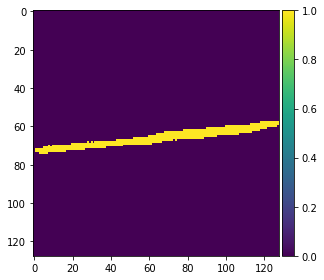

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


imshow(X_train[2])
plt.show()
imshow(np.squeeze(Y_train[2]))
plt.show()
imshow(np.squeeze(preds_train_t[2]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


imshow(X_train[int(X_train.shape[0]*0.9):][2])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][2]))
plt.show()
imshow(np.squeeze(preds_val_t[2]))
plt.show()